<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/09_SkimLit_NLP_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading material abstracts easier.

The paper we are replicating (the source of the dataset that we will be using is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best resutls is available here: https://arxiv.org/abs/1612.05251


## Confirm acces to GPU


In [88]:
!nvidia-smi

Thu Mar 31 05:11:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |   1433MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we will be replicating the paper above (PubMed 200 RCT), let's download the dataset they used.

We can do so from the author Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [89]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [90]:
# check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [91]:
# start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [92]:
#check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we have got some text data, it is time to understand the data.

The best way to understand it is to visualize the data.

In [93]:
# Create funciton to read the lines of a document 
def get_lines(filename):
  """
  Read filename (a text filename) and returns the lines oof text as a list.

  Args:
  filename: a string containing the target filepath.

  Return:
  A list of string with one string per line from the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [94]:
#let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") #read teh lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [95]:
len(train_lines)

210040

Let's thing about how we want our data to look

How I think our data would be best represented...

`[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "text".\n
   'total_lines': 11 },
   ...]`

In [96]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """

  input_lines = get_lines(filename) #get all lines from filename
  abstract_line= "" #create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  #loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the line is an ID line

    elif line.isspace(): #check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      #iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}#create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number #what number line does the line appear 
        line_data["total_lines"] = len(abstract_line_split) - 1 #how many total lines are there in the target abstract?
      abstract_samples.append(line_data) #add line data to abstract samples list

    else: #if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [97]:
#get data from file and process it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") #dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

15000 2500 2500
CPU times: user 864 ms, sys: 79.1 ms, total: 943 ms
Wall time: 1.19 s


In [98]:
#check the first abstract of our training data
train_samples[:10]

[{'line_number': 11,
  'target': 'CONCLUSIONS',
  'text': 'low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee oa ( clinicaltrials.gov identifier nct@ ) .',
  'total_lines': 11},
 {'line_number': 10,
  'target': 'CONCLUSIONS',
  'text': 'results further suggest that attention maintenance on food relates to eating motivation when in a neutral affective state , and might therefore be a cognitive mechanism contributing to increased food intake in general , but maybe not during sad mood .',
  'total_lines': 10},
 {'line_number': 14,
  'target': 'BACKGROUND',
  'text': 'http://www.clinicaltrials.gov number nct@ .',
  'total_lines': 14},
 {'line_number': 16,
  'target': 'BACKGROUND',
  'text': 'data management and statistical analyses were conducted independently by vertical ( paris , france ) .',
  'total_lines': 16},
 {'line_number': 11,
 

Now that our data is the format of a list of dictionaries, how about we run it into a DataFrame to further visualize our data

In [99]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(10)

,target,text,line_number,total_lines
0,CONCLUSIONS,low-dose oral prednisolone had both a short-te...,11,11
1,CONCLUSIONS,results further suggest that attention mainten...,10,10
2,BACKGROUND,http://www.clinicaltrials.gov number nct@ .,14,14
3,BACKGROUND,data management and statistical analyses were ...,16,16
4,CONCLUSIONS,the findings suggest that recall with em cause...,11,11
5,CONCLUSIONS,how the intervention can be brought to scale (...,12,12
6,CONCLUSIONS,antithrombin administration in patients with l...,9,9
7,CONCLUSIONS,non-transferred patients presenting to primary...,10,10
8,CONCLUSIONS,we found no benefit in survival or severity of...,8,8
9,CONCLUSIONS,this pattern of increased activations in fh + ...,7,7


In [100]:
#Distribution of labels in training data
train_df.target.value_counts()

CONCLUSIONS    11973
BACKGROUND      2692
METHODS          228
RESULTS          106
OBJECTIVE          1
Name: target, dtype: int64

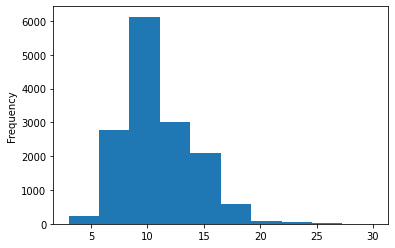

In [101]:
# let's check the length of different lines
train_df.total_lines.plot.hist();

###Get list of sentences

In [102]:
#convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences= test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(15000, 2500, 2500)

In [103]:
#view the 19 lines of training sentences
train_sentences[:10]

['low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee oa ( clinicaltrials.gov identifier nct@ ) .',
 'results further suggest that attention maintenance on food relates to eating motivation when in a neutral affective state , and might therefore be a cognitive mechanism contributing to increased food intake in general , but maybe not during sad mood .',
 'http://www.clinicaltrials.gov number nct@ .',
 'data management and statistical analyses were conducted independently by vertical ( paris , france ) .',
 'the findings suggest that recall with em causes @-hchanges in memory vividness/emotionality , which may explain part of the emdr treatment effect , and these effects are related to intervention duration .',
 'how the intervention can be brought to scale ( in particular , how to train physicians to use mi effectively and how best to 

##  Make numeric labels (ML models require numeric labels)

In [104]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1,))


#check what one hot encoded labels look like
train_labels_one_hot

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [105]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(15000, 5), dtype=float64, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [106]:
import sklearn
print(sklearn.__version__)

1.0.2


## Label encode labels

In [107]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([1, 1, 0, ..., 1, 1, 1])

In [108]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(4, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'RESULTS'], dtype=object))

## Starting a series of modelling experiments...

As usual, we are going to be trying a bunch of different models and seeing which one works best. 
And as alaways, we are going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer #turn text to number
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

#Fit the pipeline into the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [110]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
                 y = val_labels_encoded)

0.9328

In [111]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 1, 1, ..., 1, 1, 1])

In [112]:
val_labels_encoded

array([1, 1, 1, ..., 1, 1, 1])

## Download helper_function script


In [113]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-31 05:11:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-31 05:11:46 (45.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [114]:
from helper_functions import calculate_results

In [115]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 93.28,
 'f1': 0.9221296639297097,
 'precision': 0.9118391760786424,
 'recall': 0.9328}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we have got to create vectorization and embedding layers.

In [116]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [117]:
#how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len



20.316933333333335

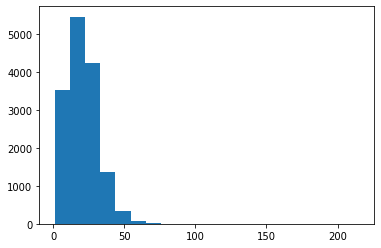

In [118]:
#what is the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [119]:
#how long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

40

In [120]:
# Maximum sequence length in the training set
max(sent_lens)

215

### Create text vectorizer layer

we want to make a layer which maps our text from words to numbers

In [121]:
#how many words are in vocab? (taken from table 2 in: https://arxiv.org/abs/1612.05251)
max_tokens = 68000

In [122]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens, #number of word in vocab
                                    output_sequence_length = output_seq_len) #desired output length of vectorized sequences

In [123]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [124]:
# test out text vectorizer on random sentences
import random
target_sentences = random.choice(train_sentences)
print(f"Text:\n{target_sentences}")
print(f"\nLength of the text: {len(target_sentences)}")
print(f"\vVectorized text:{text_vectorizer([target_sentences])}")

Text:
decreased il-@ and increased il-@ levels are two important reasons forimmunosuppression after homologous blood transfusion , whereas autologous blood transfusion can alleviate this while increasing the tnf - level , which also has potential to improve anti-tumor immunity in the human body .

Length of the text: 291
Vectorized text:[[  286   637     4    95   637    89    29   290   171  2057 17296    35
  16609   153  1161   708  2579   153  1161    33  1918    15   252   307
      2  2149   156    80   148    75    93     6    49  3035  1974     5
      2   673   327     0]]


In [125]:
#how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 20772
Most common words in the vocab: ['', '[UNK]', 'the', 'of', 'and']
Least common words in the vocab: ['aads', 'aadrenoceptor', 'aad', 'aaca', 'aaaaiawc']


In [126]:
# get the config of our text vectorizer 
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 40,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding


In [127]:
# create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim = 128, # Note: different embedding sizes result in drastically different number of paratemeters to train
                               mask_zero = True, #use masking to handle variable sequence lengths (Save space)
                               name ="token_embedding")

In [128]:
#show example embedding 
print(f"Sentence before vectorization\n {target_sentences}\n")
vectorized_sentences = text_vectorizer([target_sentences])
print(f"Sentence after vectorizer (before embedding):\n {vectorized_sentences}\n")
embedded_sentences = token_embed(vectorized_sentences)
print(f"Sentence after embedding:\n {embedded_sentences}\n")
print(f"Embedded sentence shape: {embedded_sentences.shape}")

Sentence before vectorization
 decreased il-@ and increased il-@ levels are two important reasons forimmunosuppression after homologous blood transfusion , whereas autologous blood transfusion can alleviate this while increasing the tnf - level , which also has potential to improve anti-tumor immunity in the human body .

Sentence after vectorizer (before embedding):
 [[  286   637     4    95   637    89    29   290   171  2057 17296    35
  16609   153  1161   708  2579   153  1161    33  1918    15   252   307
      2  2149   156    80   148    75    93     6    49  3035  1974     5
      2   673   327     0]]

Sentence after embedding:
 [[[ 0.00151806 -0.042282    0.00711529 ... -0.0136866  -0.01069955
   -0.04352454]
  [ 0.01157571 -0.02471237  0.03389968 ... -0.02239218  0.01539164
   -0.0180009 ]
  [-0.0345533   0.00375786 -0.04400572 ... -0.03030902 -0.02622683
    0.0218258 ]
  ...
  [ 0.01491991 -0.00625019 -0.00158475 ...  0.00421797 -0.01078568
   -0.02193412]
  [ 0.0400806

## Creating datasets (making sure our data loads as fast as possible) using TensorFlow tf.data API

https://www.tensorflow.org/guide/data

https://www.tensorflow.org/guide/data_performance

In [129]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [130]:
#Take the TensorSlicesDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1:Conv1D with token embeddings

In [131]:
# create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
#expand_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x , axis =1))
#x = expand_layer(token_embeddings)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu") (token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)
#outputs = tf.expand_dims(outputs, axis=-1)
model_1 = tf.keras.Model(inputs, outputs)

#compile 
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [132]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 40)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 40, 128)          2658816   
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 5)                 325 

In [133]:
#fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset))) #only validate on 10% of batches

Epoch 1/3
46/46 [==============================] - 4s 39ms/step - loss: 1.0187 - accuracy: 0.7785 - val_loss: 0.6930 - val_accuracy: 0.7902
Epoch 2/3
46/46 [==============================] - 1s 18ms/step - loss: 0.4874 - accuracy: 0.8145 - val_loss: 0.4044 - val_accuracy: 0.9062
Epoch 3/3
46/46 [==============================] - 1s 18ms/step - loss: 0.2949 - accuracy: 0.9307 - val_loss: 0.3182 - val_accuracy: 0.9062


In [134]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

79/79 [==============================] - 1s 10ms/step - loss: 0.2722 - accuracy: 0.9228


[0.272219717502594, 0.9228000044822693]

In [135]:
#make prediction (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[7.4718832e-06, 9.9972516e-01, 3.1028867e-05, 1.3455920e-05,
         2.2282994e-04],
        [7.0521724e-05, 9.9891865e-01, 1.6755848e-04, 6.7251298e-05,
         7.7609858e-04],
        [1.2703239e-03, 9.9601907e-01, 8.0242660e-04, 1.7267928e-04,
         1.7355124e-03],
        ...,
        [1.0970422e-02, 9.8066026e-01, 3.3720082e-03, 5.7293667e-04,
         4.4244626e-03],
        [6.3505868e-06, 9.9978119e-01, 2.4693087e-05, 9.9591789e-06,
         1.7784449e-04],
        [5.9510207e-01, 3.4095234e-01, 4.0912379e-02, 4.7266535e-03,
         1.8306527e-02]], dtype=float32), (2500, 5))

In [136]:
#convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(2500,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 0])>

In [137]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'RESULTS'], dtype=object)

In [138]:
#calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 92.28,
 'f1': 0.9137161403508771,
 'precision': 0.9064106897563206,
 'recall': 0.9228}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from tensorflow hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings however, we are going to use pretrained embeddings,

In [139]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [140]:
# test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:10]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 in a health care landscape that is changing quickly and increasingly focused on the cost of care , future research should assess whether the core tenants of the child life profession support and contribute quantifiably to high-quality , cost-effective practices in health care .

Sentence after embedding:
[-0.06564198 -0.02754495  0.02126535  0.00483537 -0.08041915 -0.07766225
  0.04872744 -0.02102139  0.05548089 -0.08628363]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained model using embeddings TensoFlow Hub 

In [141]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)

outputs= layers.Dense(5, activation="softmax")(x) #create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

#compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [142]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [143]:
# fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))
                              )

Epoch 1/3
46/46 [==============================] - 10s 69ms/step - loss: 0.9524 - accuracy: 0.8791 - val_loss: 0.4438 - val_accuracy: 0.8884
Epoch 2/3
46/46 [==============================] - 2s 43ms/step - loss: 0.2801 - accuracy: 0.9287 - val_loss: 0.3142 - val_accuracy: 0.9062
Epoch 3/3
46/46 [==============================] - 2s 44ms/step - loss: 0.2315 - accuracy: 0.9416 - val_loss: 0.2661 - val_accuracy: 0.9286


In [144]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

79/79 [==============================] - 3s 36ms/step - loss: 0.2119 - accuracy: 0.9344


[0.21187397837638855, 0.9344000220298767]

In [145]:
#make prediction with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[1.8837876e-03, 9.9366814e-01, 1.4899742e-03, 1.2415308e-03,
        1.7165254e-03],
       [1.6092713e-03, 9.9564040e-01, 9.7255269e-04, 7.3640654e-04,
        1.0412952e-03],
       [2.0041803e-02, 9.2580980e-01, 2.2072189e-02, 1.4051930e-02,
        1.8024314e-02],
       ...,
       [1.5910035e-03, 9.9474961e-01, 1.1107868e-03, 1.0499322e-03,
        1.4986274e-03],
       [6.7110746e-03, 9.7606373e-01, 5.6131505e-03, 4.9404511e-03,
        6.6716671e-03],
       [2.9281607e-01, 6.6958702e-01, 1.3181923e-02, 1.1086890e-02,
        1.3328146e-02]], dtype=float32)

In [146]:
#convert the prediction probabilities to label
model_2_preds= tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(2500,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [147]:
#calculate results from TF hub pretrained mebedding resutls on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 93.44,
 'f1': 0.9239547727466692,
 'precision': 0.9140977283355889,
 'recall': 0.9344}

In [148]:
baseline_results

{'accuracy': 93.28,
 'f1': 0.9221296639297097,
 'precision': 0.9118391760786424,
 'recall': 0.9328}

## Model 3: Conv1D with character embeddings

the paper which we are replicating states they used combination of token and character-level-embeddings.
Previously, we have token-level embeddings but we will need to do similar steps for characters if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [149]:
#make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

#Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n   a   h e a l t h   c a r e   l a n d s c a p e   t h a t   i s   c h a n g i n g   q u i c k l y   a n d   i n c r e a s i n g l y   f o c u s e d   o n   t h e   c o s t   o f   c a r e   ,   f u t u r e   r e s e a r c h   s h o u l d   a s s e s s   w h e t h e r   t h e   c o r e   t e n a n t s   o f   t h e   c h i l d   l i f e   p r o f e s s i o n   s u p p o r t   a n d   c o n t r i b u t e   q u a n t i f i a b l y   t o   h i g h - q u a l i t y   ,   c o s t - e f f e c t i v e   p r a c t i c e s   i n   h e a l t h   c a r e   .'

In [150]:
#Split sequence-level-data splits into character-level splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['l o w - d o s e   o r a l   p r e d n i s o l o n e   h a d   b o t h   a   s h o r t - t e r m   a n d   a   l o n g e r   s u s t a i n e d   e f f e c t   r e s u l t i n g   i n   l e s s   k n e e   p a i n   ,   b e t t e r   p h y s i c a l   f u n c t i o n   ,   a n d   a t t e n u a t i o n   o f   s y s t e m i c   i n f l a m m a t i o n   i n   o l d e r   p a t i e n t s   w i t h   k n e e   o a   (   c l i n i c a l t r i a l s . g o v   i d e n t i f i e r   n c t @   )   .',
 'r e s u l t s   f u r t h e r   s u g g e s t   t h a t   a t t e n t i o n   m a i n t e n a n c e   o n   f o o d   r e l a t e s   t o   e a t i n g   m o t i v a t i o n   w h e n   i n   a   n e u t r a l   a f f e c t i v e   s t a t e   ,   a n d   m i g h t   t h e r e f o r e   b e   a   c o g n i t i v e   m e c h a n i s m   c o n t r i b u t i n g   t o   i n c r e a s e d   f o o d   i n t a k e   i n   g e n e r a l   ,   b u t   m a y b e   n o t   d u r i n g   s a d   m o o d 

In [151]:
#what is the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

129.99693333333335

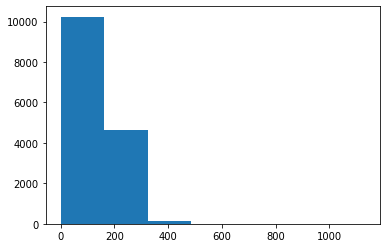

In [152]:
#check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [153]:
#find what character length cover 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

255

In [154]:
# get all keyboard characters
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [155]:
#create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) +2 # add 2 for space and OOV token (OOV = out of vocab. '[UNK] = unknown)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #standardize="lower_and_strip_punctuation", 
                                    name="char_vectorizer")

In [156]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [157]:
#check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: k


In [158]:
#test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorizerd chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 (   f u n d e d   b y   t h e   n a t i o n a l   i n s t i t u t e   f o r   h e a l t h   r e s e a r c h   h e a l t h   t e c h n o l o g y   a s s e s s m e n t   p r o g r a m   ;   c u r r e n t   c o n t r o l l e d   t r i a l s   n u m b e r   ,   i s r c t n @   .   )
Length of random_train_chars: 119

Vectorizerd chars:
 [[17 15  6 12  2 12 21 20  3 13  2  6  5  3  4  7  6  5 11  4  6  9  3  4
   3 15  3  2 17  7  8 13  2  5 11  3 13  8  2  9  2  5  8 10 13 13  2  5
  11  3 13  3  2 10 13  6  7 11  7 18 20  5  9  9  2  9  9 16  2  6  3 14
   8  7 18  8  5 16 10 15  8  8  2  6  3 10  7  6  3  8  7 11 11  2 12  3
   8  4  5 11  9  6 15 16 21  2  8  4  9  8 10  3  6  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a character-level embedding

In [159]:
#create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), #number of different chars
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")



In [160]:
#test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 (   f u n d e d   b y   t h e   n a t i o n a l   i n s t i t u t e   f o r   h e a l t h   r e s e a r c h   h e a l t h   t e c h n o l o g y   a s s e s s m e n t   p r o g r a m   ;   c u r r e n t   c o n t r o l l e d   t r i a l s   n u m b e r   ,   i s r c t n @   .   )

Embedded chars. (after vectorization and embedding):
 [[[-0.01440571  0.00854691 -0.01567928 ... -0.02419779  0.02044915
   -0.01097576]
  [ 0.00142597 -0.02935236 -0.03659514 ... -0.03295841  0.00272597
    0.03167802]
  [ 0.0023849   0.01433749  0.01896602 ... -0.01387459 -0.01027585
    0.04941956]
  ...
  [-0.04907114 -0.01607309  0.01623105 ...  0.04282507  0.03753478
   -0.01579183]
  [-0.04907114 -0.01607309  0.01623105 ...  0.04282507  0.03753478
   -0.01579183]
  [-0.04907114 -0.01607309  0.01623105 ...  0.04282507  0.03753478
   -0.01579183]]]

Character embedding shape: (1, 255, 25)


## Building a Conv1D model to fit on character embeddings

In [161]:
#Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

#compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [162]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 255)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 255, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 255, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 

In [163]:
#create cahr level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [164]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [165]:
#fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=len(val_char_dataset))

Epoch 1/3
46/46 [==============================] - 3s 37ms/step - loss: 1.1601 - accuracy: 0.7045 - val_loss: 0.6669 - val_accuracy: 0.8012
Epoch 2/3
46/46 [==============================] - 1s 24ms/step - loss: 0.5202 - accuracy: 0.8010 - val_loss: 0.4424 - val_accuracy: 0.8156
Epoch 3/3
46/46 [==============================] - 1s 25ms/step - loss: 0.3992 - accuracy: 0.8533 - val_loss: 0.3708 - val_accuracy: 0.8616


In [166]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.0451142 , 0.9462598 , 0.00261498, 0.0016863 , 0.00432475],
       [0.05809811, 0.9333915 , 0.00271826, 0.00168855, 0.00410359],
       [0.07058377, 0.91800964, 0.00341326, 0.00233578, 0.00565747],
       ...,
       [0.09841599, 0.8838471 , 0.00551152, 0.0039197 , 0.00830565],
       [0.04073191, 0.95194846, 0.00231971, 0.00149167, 0.00350821],
       [0.31576765, 0.65750986, 0.00755791, 0.0049541 , 0.0142105 ]],
      dtype=float32)

In [167]:
#convert pred prob into class label
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(2500,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [168]:
#calculate results for Conv1D models chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 86.16,
 'f1': 0.8347843500732189,
 'precision': 0.8357838590920059,
 'recall': 0.8616}

## Model 4: Combining pretrained  token embedding + characters embeddings (hybrid model)

1. Create a token-level embedding level (similar `model_1`)

2. Create a character-level model (similar t0 `model_3` with a slight modification)

3. Combine 1& 2 with a concatenate (`layer.Concatenate`)

4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/abs/1612.05251

5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [169]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/abs/1612.05251
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybridd token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding, discussed in section 4.2 of https://arxiv.org/abs/1612.05251
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combine_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combine_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Contruct model with char and 
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings") 

In [170]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 255)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

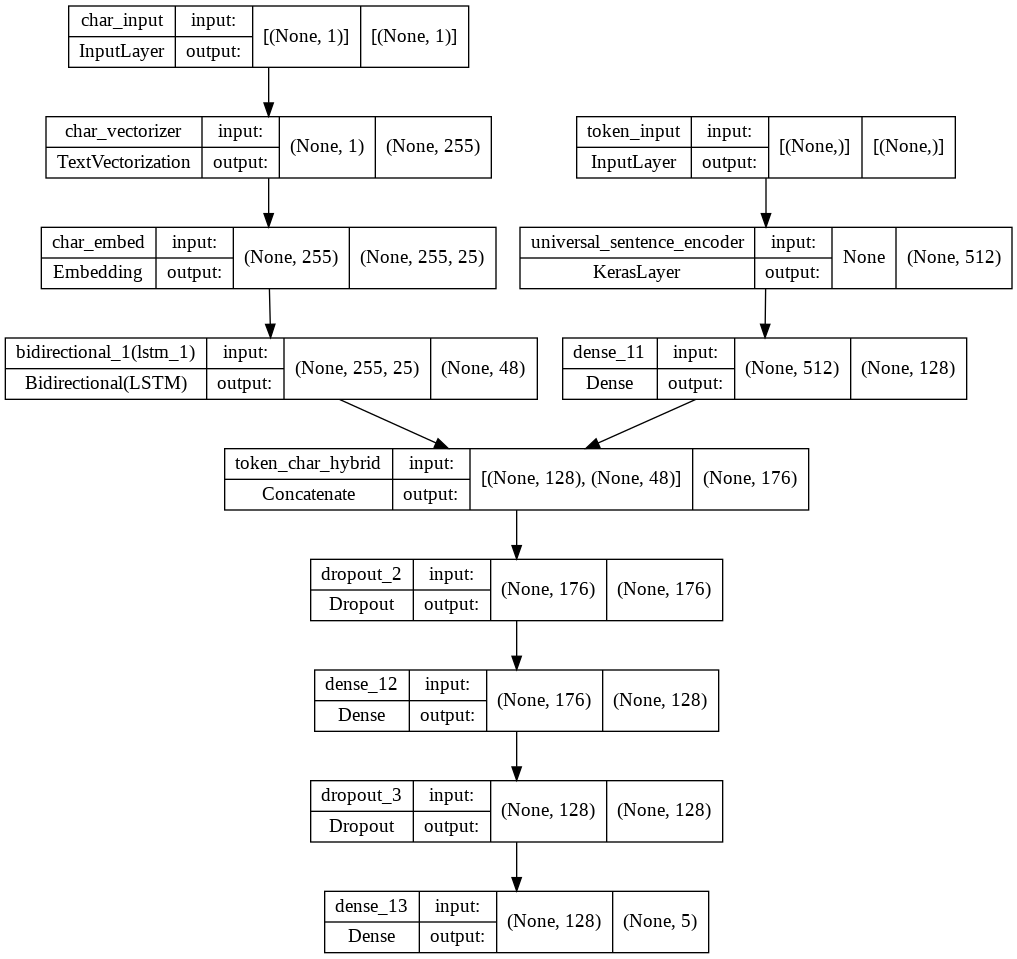

In [172]:
#plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [173]:
#compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining chars and tokens data into a tf.data Dataset

In [176]:
#combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

#prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [179]:
#repeat the above steps for our validatin data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [180]:
#check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)